# Gradient Descent Optimization

In the ``demo_breast_cancer.ipynb``, we used the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this demo, we will build a very simple gradient descent optimizer from scratch.  You will learn to:
* Compute the gradients of a loss function and implement the gradient calculations in python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm
* Add regularization to the loss minimization problem
* Try out different black-box optimizers in Python

## Loading the Breast Cancer Data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import preprocessing

We next load the data from the [breast cancer demo](../logistic/breast_cancer.ipynb).  

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


As in the breast cancer demo, we create a data matrix `X` of various features of the breast cancer sample.  The response vector `y` is a binary indicating if each sample is benign or malignant.  

In [3]:
# Get the predictors
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
Xraw = np.array(df[xnames])
# As usual, let's also append an all ones vector onto X to serve as the intercept feature
X = np.concatenate((np.ones((Xraw.shape[0],1)),Xraw),axis=1)

# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int) # now y has values of 0,1 
Iben = (y==0)
Imal = (y==1)

We want to learn the classification rule to predict `y` from `X`.  We will do so with logistic regression.

## Computing the Gradient and Loss Function

Recall that training a logistic function means finding a weight vector $\beta$ for the classification rule:
* Predict 1 for data vector $\vec{x}$ if $\frac{1}{1 + e^{-\vec{x}^T\vec{\beta}}} > 1/2$, i.e. if $\vec{x}^T\vec{\beta} > 0$. 
* Predict 0 for data vector $\vec{x}$ if $\frac{1}{1 + e^{-\vec{x}^T\vec{\beta}}} \leq 1/2$, i.e. if $\vec{x}^T\vec{\beta} \leq 0$.

Let $h_{\vec{\beta}}(\vec{x}) = \frac{1}{1 + e^{-\vec{x}^T\vec{\beta}}}$. To find $\beta$, we minimize the cross-entropy loss (aka the logistic loss):
$$
L(\vec{\beta}) = - \sum_{i=1}^n y_i \log(h_{\vec{\beta}}(\vec{x}_i)) + (1-y_i) \log(1-h_{\vec{\beta}}(\vec{x}_i)).
$$
As show in class we have
$$
\nabla L(\vec{\beta}) = \mathbf{X}^T(h_{\vec{\beta}}(\mathbf{X}) - y)
$$
where $h_{\vec{\beta}}(\mathbf{X})$ denotes the vector obtained by applying $h$ to every row in $\mathbf{X}$. 
    
    
We will first write a function to compute `L` and its gradient `Lgrad`. One issue with the gradient is that directly computing $L$ using the expression above can be *numerically unstable*. A student brought up this issue in lecture: essentially what can happen is you end up taking logs of numbers very close to zero and Python will return NaNs due to issues with using finite precision arithmetic. To deal with this problem, we write down an alternative expression for `L` which is *mathematically equivalent* but can be computed more accurately in finite precision arithmetic:
$$
L(\vec{\beta}) = \sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i)).
$$

In [4]:
def Leval(beta,X,y):
    """
    Compute the loss and gradient given beta,X,y
    """
    z = X@beta
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h))

    # Gradient
    Lgrad = (X.T)@(h-y)
    return L, Lgrad

We can test our function on a random parameter vector $\vec{\beta}_0$.

In [5]:
# Some random point
p = X.shape[1]
beta0 = np.random.randn(p)

# Call the function
L, Lgrad = Leval(beta0,X,y)

It's not ideal that the loss function `L(beta,X,y)` depends on the parameters `X` and `y`.  Most numerical optimizers expect a function that only depends on `beta`. We can acheive this by using a Python `lambda` function to fix the parameters `X` and `y`.

In [6]:
# Create a function with X,y fixed
Leval_param = lambda beta: Leval(beta,X,y)

# You can now pass a parameter like w0
L0, Lgrad0 = Leval_param(beta0)

### Testing the gradient

Whenever you write a function for computing a gradient, it is very important to test if the gradient is correct.  This is the number one reason people's code does not work with numerical optimizers.  The simplest method is to take two points `beta0` and `beta1` that are close to one another and then verify that:
$$
L(\vec{\beta}_1) - L(\vec{\beta}_0) \approx \langle \nabla L(\vec{\beta}_0), \vec{\beta}_1 - \vec{\beta}_0\rangle.
$$

In [7]:
# Take a random initial point
p = X.shape[1]
beta0 = np.random.randn(p)

# Perturb the point
step = 1e-6
beta1 = beta0 + step*np.random.randn(p)

# Measure the function and gradient at w0 and w1
L0, Lgrad0 = Leval_param(beta0)
L1, Lgrad1 = Leval_param(beta1)

# Predict the amount the function should have changed based on the gradient
dL_est = Lgrad0.T@(beta1-beta0)

# Print the two values to see if they are close
print("Actual L1-L0    = %12.4e" % (L1-L0))
print("Predicted L1-L0 = %12.4e" % dL_est)

Actual L1-L0    =   1.7610e-03
Predicted L1-L0 =   1.7610e-03


You can see that the two agree well. You can run the block multiple times to get different answers (depending on the random choice of $\beta_0$, but you always see agreement.

## A Simple Gradient Descent Optimizer

Now, we build a simple gradient descent optimizer function with a fixed learning rate.

In [8]:
def grad_opt_simp(grad_func, beta0, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization
    
    grad_func:  A function that returns the objective function L, and its gradient Leval
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nit:    Number of iterations
    """
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'beta': [], 'L': []}
    
    # initialize
    beta = beta0
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        L, Lgrad = grad_func(beta)

        # Take a gradient step
        beta = beta - lr*Lgrad
        
         # Save history
        hist['L'].append(L)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist

We now run the gradient descent starting from a initial condition of $\vec{\beta}_0 = \vec{0}$.

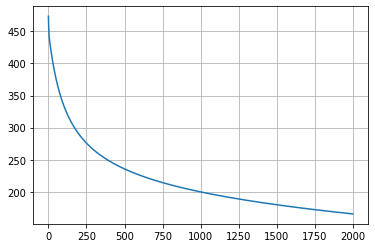

In [9]:
# Initial condition
beta0 = np.zeros(p)

# Parameters
nit = 2000
lr = 1e-5

# Run the gradient descent
beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.plot(t, hist['L'])
plt.grid()

We can measure the accuracy of the final estimate by creating a predict method.

In [10]:
def predict(X,beta):
    z = X@beta
    yhat = (z > 0)
    return (1*yhat)

In [11]:
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("Train accuracy = %f" % acc)

Train accuracy = 0.941435


This is not quite as good as the accuracy for the `sklearn` method from the demo, which was about 98.5%.  The reason is that the learning rate was somewhat slow and we didn't yet fully converge.

To see the effect of the learning rate, the code below tries different learning rates.

lr=    1.00e-05  Train accuracy = 0.941435
lr=    1.00e-04  Train accuracy = 0.969253
lr=    1.00e-03  Train accuracy = 0.970717


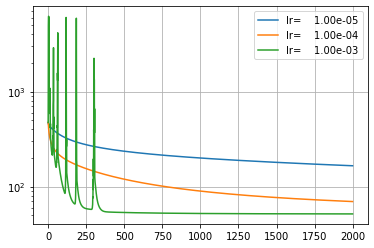

In [12]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3]
ntest = len(lr_test)

# Strings for the legend
leg_str = []

beta0 = np.zeros(p)
for i in range(ntest):
    # Run the optimizer
    beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr_test[i], nit=nit)    
    
    # Plot the results
    plt.semilogy(t, hist['L'])
    leg_str.append("lr=%12.2e" % lr_test[i])
    
    # Measure the train accuracy
    yhat = predict(X,beta)
    acc = np.mean(yhat == y)
    print("lr=%12.2e  Train accuracy = %f" % (lr_test[i], acc))
    
plt.grid()
plt.legend(leg_str, loc='upper right')

We see that increasing the learning rate, speeds the convergence time, but the optimization is beginning to go unstable. It recovers from this instability for learning rate `1e-3`, but try running with rate `1e-2` to see more of an issue.

## Adaptive Step Size

The above example shows that gradient descent is sensitive to the step size.  We now consider a variant of gradient descent with an adaptive step-size using the Armijo rule discussed in class.

In [13]:
def grad_opt_adapt(grad_func, beta0, nit=2000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    beta0:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """
    
    # Set initial point
    beta = beta0
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'beta': [], 'L': []}

    L,Lgrad = grad_func(beta0)
    for it in range(nit):

        # Take a gradient step
        beta1 = beta - lr*Lgrad

        # Evaluate the test point by computing the objective function, L1,
        # at the test point and the predicted decrease, df_est
        L1, Lgrad1 = grad_func(beta1)
        df_est = Lgrad.T@(beta1-beta)
        
        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (L1-L < alpha*df_est) and (L1 < L):
            # If descent is sufficient, accept the point and increase the learning rate
            lr = lr*2
            L = L1
            Lgrad = Lgrad1
            beta = beta1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2            
            
        # Save history
        hist['L'].append(L)
        hist['lr'].append(lr)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'lr', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist


We can now run the new optimizer.

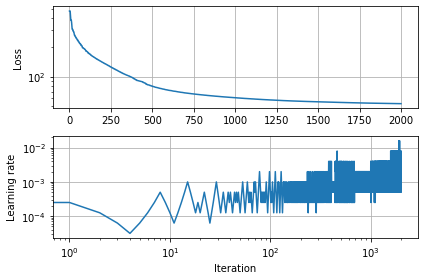

In [14]:
beta0 = np.zeros(p)
nit = 2000
beta, L, hist = grad_opt_adapt(Leval_param, beta0, nit=nit)

t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogy(t, hist['L'])
plt.grid()
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.tight_layout()

Finally we measure the accuracy and see that we performed as well as the best fixed step size used above.

In [15]:
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("Train accuracy = %f" % acc)

Train accuracy = 0.970717


## L2 Regularization

Just as for linear regression, given enough features, logsitic regression can be prone to overfitting. In such cases, it often make sense to add regularization when training. In particular, instead of minimizing:
$$
L(\mathbf{\vec{\beta}}) =\sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i)).
$$
we might use $\ell_2$ regularization and choose $\beta$ to minimize
$$
L_R(\vec{\beta}) = L(\vec{\beta}) + \lambda \|\vec{\beta}\|_2^2
$$
for some regularization parameter $\lambda$. 

Write a function which evaluates the regularized loss `Lr` for parameters `beta` and also computes the gradient $\nabla L_R(\vec{\beta})$ at `beta`. You will have to derive an expression for this gradient to correctly implement your function.

In [16]:
def Leval_reg(beta,X,y,lamb):
    """
    Compute the regularized loss and gradient given beta, X, y, and regularization parameter lamb
    """
    # TODO
    # Lr =
    # Lrgrad

    return Lr, Lrgrad

As we did above for the unregularized loss, write code to test your gradient computation. Run your test for `lamb` equals `0`,`1`,`10`,`100` and print output which confirms the accuracy of your gradient in all cases.

In [17]:
# TODO


For `lamb` equals `0`,`1`,`10`,`100` use `grad_opt_adapt` run for `2000` iterations with $\vec{\beta}_0 = \vec{0}$ to find a parameter vector $\beta$ which approximately minimizes $L_R(\beta)$. For each regularization level, print the train accuracy achieved when using the optimal parameters. Note that we expect the **train accuracy to decrease** as the regularization parameter increases. Regularization often helps **test accuracy to increase**, but for this lab we're keeping things simple without a test set.

In [18]:
# TODO


# These are the outputs I got:
# lamb = 0, Train accuracy = 0.970717
# lamb = 1, Train accuracy = 0.969253
# lamb = 10, Train accuracy = 0.959004
# lamb = 100, Train accuracy = 0.920937

## Kernel Logistic Regression, Linear Kernel

Logistic regression works nicely with non-linear kernels, which can significantly improve its accuracy for certain problems. We will see an example in our next lab on classifying MNIST images. 

To use logistic regression with a kernel, our first step was to reparameterize the logistic loss function by replacing $\vec{\beta}\in \mathbb{R}^d$ with $\mathbf{X}^T\vec{\alpha}$ where $\vec{\alpha}\in \mathbb{R}^n$ is a new parameter vector.  

Our loss becomes:
$$
L(\vec{\alpha}) =\sum_{i=1}^n (1-y_i)(\vec{x}_i^T\mathbf{X}^T\vec{\alpha}) - \log(h_{\mathbf{X}^T\vec{\alpha}}(\vec{x}_i)).
$$
The regularized loss becomes:
$$
L_R(\vec{\alpha}) = L(\vec{\alpha}) + \lambda \|\vec{X}^T\vec{\alpha}\|_2^2
$$

Write a function which evaluates the regularized loss `Lr` for parameters `alpha` and also computes the gradient $\nabla L_R(\vec{\alpha})$ at `alpha`. Again, you will have to derive an expression for this gradient to implement your function. 

**Note**: We are not doing anything with a non-linear kernel yet, but we will in the next lab! Here we are just going through the first step of reformulating our logistic regression model to eventually use different kernels.

In [19]:
def Leval_reg_linear_kernel(alpha,X,y,lamb):
    """
    Compute the regularized loss and gradient given beta, X, y, and regularization parameter lamb
    """
    # TODO
    # Lr =
    # Lrgrad

    return Lr, Lrgrad

Even though our reformuation leads to an equivalent loss function and regularization term, the updates performed by the gradient descent optimizer are not exactly the same. In fact, after reparameterization, we can see that gradient descent converges much more slowly to a solution. 

To see this yourself, run `grad_opt_adapt` for `5000` steps to minimize the regularized logistic regression loss for data `X`,`y` with `lamb = 10`, using both the original formulation (involving `beta`) and the reparameterized formulation, involving `alpha`. Plot the history of how the loss function decreases over time a single plot with two lines: one for the original formulation and one for the reparameterization. Include axis labels and a legend.

In [20]:
nit = 5000
l = 10
beta0 = np.zeros(X.shape[1])
alpha0 = np.zeros(X.shape[0])

# TODO
# Optimize alpha via gradient descent
# Optimize beta via gradient descent
# Generate plot

After `5000` steps, what is the minimum regularized objective function value acheived for each formulation of the problem? 

In [21]:
# TODO 
# Print minimum objective values

Fortunately, when gradient descent converges slowly, there are other first-order optimization algorithms that can be used in its place, and often converge much faster. Here we will try using some built-in optimization methods for the `scipy` library in Python. In particular, we use the function `scipy.optimize.minimize` which is documented [here](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.optimize.minimize.html).

This function takes many inputs. The two most important ones are the `fun` and `jac` arguments, which should be passed Python functions for 1) evaluating the function we want to minimize at an point and 2) evaluating the gradient of the function at any point. `jac` is short for "Jacobian" which is a generalization of the gradient for multi-output functions. Since we're dealing with a loss function which just has one output, the Jacobian is equal to the gradient.

Run the code below for minimizing the reparameterized regularized loss using the ["BFGS" algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).

In [22]:
import scipy

In [23]:
l = 10
# function for computing regularized loss
f = lambda alpha: Leval_reg_linear_kernel(alpha,X,y,l)[0]
# function for computing gradient of regularized loss
g = lambda alpha: Leval_reg_linear_kernel(alpha,X,y,l)[1]
alpha0 = np.zeros(X.shape[0])
# res stores the result of scipy.optimize.minimize, which contains a number of pieces of information
res = scipy.optimize.minimize(f, alpha0, args=(), method='BFGS', jac=g) 
# we're most interest in the minimizing argument, which can be obtained via res.x
alpha = res.x
# we check the objective value obtained
Leval_reg_linear_kernel(alpha,X,y,l)[0]

NameError: name 'Lr' is not defined

You should observe a loss much closer to minimum obtained before reparameterization (which is very close to the true minimum), and the method runs in a fraction of the time that gradient descent would have required! You can time how long the solvers take to converge using the following code. 

In [ ]:
import time

In [ ]:
t = time.time()
scipy.optimize.minimize(f, alpha0, args=(), method='newton-cg', jac=g) 
elapsed = time.time() - t
print("Elapsed time: " + str(elapsed))
alpha = res.x
print("Minimum loss value: " + str(Leval_reg_linear_kernel(alpha,X,y,l)[0]))

Refering the documentation try out different algorithms for `scipy.optimize.minimize`. Find a first-order method (only requires gradients) which provides a comparable solution to `BFGS` but in less time. Note the method here.

In [ ]:
# TODO What's a faster method for this problem? 